# Disposition FM model

Import libraries and packages
Define the NN-model

Train said model:
Optimizer, learning rate.
Define loss function (MSE)

Implement a for-loop that goes for the desired amount of training steps
For each iteration:
Generate samples from a dataset (e.g. 256 trajectories from a 10 000 trajectory dataset)
Convert into PyTorch tensor

Generate intial state at random, make sure they have the same shape as the samples
Sample random time steps, assign each trajectory with a time sampled from a uniform distribution [0,1]

Interpolate between the dataset sample (x1) and the initial state (x0)
The interpolated state (xt) is then sued to compute the target velocity field
dxt = x1-x0
dxt is the velocity field, defined as the difference between x1 and x0 (i.e. the direction for the trajectory to move)

Optimize the flow model, measure the loss, store the loss
Backpropagation, update parameters

Sample from the trained model

Plot progression
Store plots

# Trajectory considerations:
For full trajectories instead of points, each trajectory should be stored as a sequence, where x_t represents the system's state at time t.
Instead of sampling x1 and x0 randomly, I should instead sample a full trajectory, choose two time steps within the traj and interpolate between the x(t_0) and x(t_1) for those time steps.
Interpolation: alpha=(t-t0)/(t1-t0)
Loss function should minimize diff between learned vel: flow(xt,t)  and true vel: dxt

In [2]:
import torch
from torch import nn, Tensor
import matplotlib.pyplot as plt
import numpy as np
import tqdm as tqdm
import random

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
print(f"CUDA version: {torch.version.cuda}")
torch.cuda.set_device('cuda:0')

Device: cuda:0
CUDA version: 12.6


In [4]:
class Flow(nn.Module):
    def __init__(self, dim: int = 2, h: int = 64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim + 1, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, dim))

    def forward(self, t: Tensor, x_t: Tensor) -> Tensor:
        return self.net(torch.cat((t, x_t), -1))

    def step(self, x_t: Tensor, t_start: Tensor, t_end: Tensor) -> Tensor:
        t_start = t_start.view(1, 1).expand(x_t.shape[0], 1)
        return x_t + (t_end - t_start) * self(t=t_start + (t_end - t_start) / 2, x_t= x_t + self(x_t=x_t, t=t_start) * (t_end - t_start) / 2)

In [5]:
flow = Flow().to(device)
optimizer = torch.optim.AdamW(flow.parameters(), 1e-3)
loss_fn = nn.MSELoss()

In [ ]:
loaded_trajectories = torch.load('trajectories.pth', weights_only=False)
trajectories_tensor = [
    (torch.tensor(traj, dtype=torch.float32, device=device), torch.tensor(times, dtype=torch.float32, device=device))
    for traj, times in loaded_trajectories
]

print(f"dataset: {trajectories_tensor}")
training_steps = 10000
pbar = tqdm.tqdm(range(training_steps))

for i in pbar:
    trajectory, times = trajectories_tensor[random.randint(0, len(trajectories_tensor)-1)]

    t0_idx, t1_idx = torch.randint(0, len(times)-1 , (2,), device=device) # Take two random samples from a trajectory
    t0, t1 = times[t0_idx], times[t1_idx] # get the corresponding time to the two random samples
    x_t0, x_t1 = trajectory[t0_idx], trajectory[t1_idx] # get the corresponding trajectory "positions"

    alpha = torch.rand(1,device=device) # Interpolation factor
    t = (1 - alpha) * t0 + alpha * t1_idx # Interpolate time 
    x_t = (1 - alpha) * x_t0 + alpha * x_t1 # Interpolate "location"
    dx_t = (x_t1 - x_t0) / (t1 - t0) # Calculate velocity field

    optimizer.zero_grad() # Optimize
    loss_fn(flow(x_t, t), dx_t).backward() # Backpropagate
    optimizer.step() # Next step


## Sampling

Done sampling


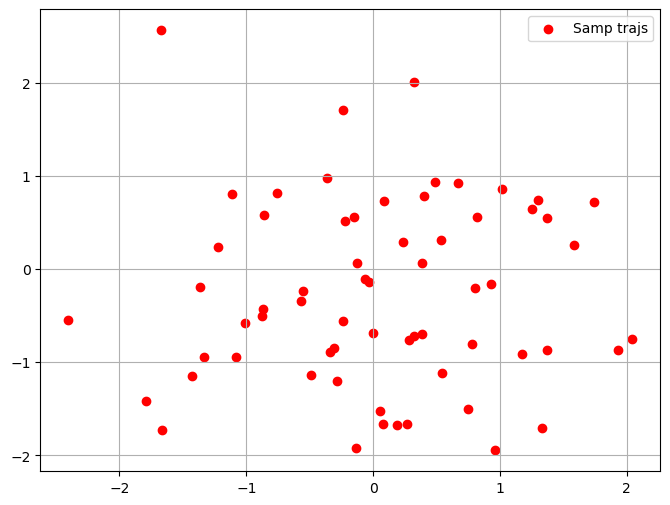

In [6]:
# Sampling parameters
batch_size = 64
sampling_steps = 10000
t_start = 0.0
t_end = 1.0
dt = (t_end - t_start) / sampling_steps
state_dim = 2 # Traj points are 2D

# Create noisy trajectories 
flow.eval()
losses = []

with torch.no_grad():
    x = torch.randn(batch_size, state_dim, device=device)
    trajectory_record = [x.unsqueeze(0)] # shape: (1, batch_size, state_dim)
    
    # Solve ODE with Euler or higher order solver (e.g RK, adaptive solvers)
    for step in range(sampling_steps):
        current_time = torch.tensor([t_start + step * dt], dtype=x.dtype, device=device).expand(batch_size, 1)
        v = flow(current_time, x)
        x = x + dt * v
        
        trajectory_record.append(x.unsqueeze(0))
    samp_trajs = torch.cat(trajectory_record, dim=0)
print("Done sampling")

points = samp_trajs[0, :].cpu().numpy()

plt.figure(figsize=(8,6))
plt.scatter(points[:, 0], points[:, 1], color="r", label="Samp trajs")
plt.legend()
plt.grid()
plt.show()
